In [93]:
import pandas as pd
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from PIL import ImageDraw
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
url = r'C:\לימודים\סמסטר ב\הדמיית נתונים\פרוייקט גמר\dogs-vs-cats\train\train'
titles = os.listdir(url)

In [ ]:
category =[]
for title in titles:
    title = title.split('.')[0]
    if title == "cat":
        category.append(0)
    else:
        category.append(1)
categories = pd.DataFrame({'title': titles , 'category': category})

In [41]:
categories

,title,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


### let's show few pictures

In [ ]:
# Create figure with 2x2 sub-plots.
def plot_images(images, labels):
  fig, axes = plt.subplots(2, 2)
  fig.subplots_adjust(hspace=0.5 , wspace=0.3)

  for i, ax in enumerate(axes.flat):
    # Plot image
    ax.imshow(mpimg.imread(images[i]))
    
    # Plot label
    ax.set_xlabel('Label : %s' % labels[i])
        
        
  plt.show()

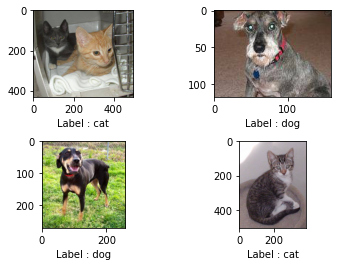

In [43]:
img_paths = []
img_labels = []
for i in range(10):
  # pick 4 random ids from the dataset
  rand_id = np.random.randint(0, len(titles))
  
  # get the img path from the id
  filename = categories.loc[rand_id, 'title'] 
  path = os.path.join(url, filename)
  img_paths.append(path)
  
  # get the img label from the id
  img_label = categories.loc[rand_id, 'category'] 
  if img_label == 1:
    img_labels.append('dog')
  else:
    img_labels.append('cat')
  
plot_images(img_paths, img_labels)

## that is before cleaning data, let's claen it!

In [ ]:
pixels = []
for t in titles:
    file = os.path.join(url , t)
    img = Image.open(file)
    resize = img.resize((100,100))
    bw = resize.convert(mode='L')
    temp = list(bw.getdata())
    pixels = pixels +[temp]
    bw.save(r'C:\לימודים\סמסטר ב\הדמיית נתונים\פרוייקט גמר\dogs-vs-cats\train\resize_bw\\' + t)

### and now, lets show the cleaning pictures

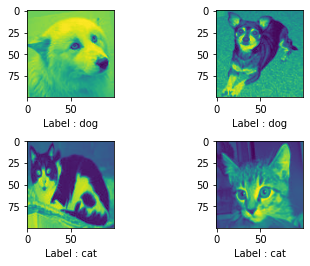

In [44]:
img_paths = []
img_labels = []
url_b = r'C:\לימודים\סמסטר ב\הדמיית נתונים\פרוייקט גמר\dogs-vs-cats\train\resize_bw'
for i in range(10):
  # pick 4 random ids from the dataset
  rand_id = np.random.randint(0, len(titles))
  
  # get the img path from the id
  filename = categories.loc[rand_id, 'title'] 
  path = os.path.join(url_b, filename)
  img_paths.append(path)
  
  # get the img label from the id
  img_label = categories.loc[rand_id, 'category'] 
  if img_label == 1:
    img_labels.append('dog')
  else:
    img_labels.append('cat')
  
plot_images(img_paths, img_labels)

In [ ]:
column = []
for i in range(0,100*100):
    column.append('pixel' + str(i))

In [ ]:
df = pd.DataFrame(data = pixels , columns = column)

In [38]:
df['label'] = categories['category']

In [39]:
df 

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999,label
0,169,173,177,182,185,188,190,194,196,198,...,3,3,2,2,2,2,2,2,2,0
1,43,43,50,47,44,39,43,42,41,53,...,51,55,56,54,68,74,68,35,36,0
2,34,31,44,46,45,53,56,56,54,56,...,163,150,134,134,146,158,169,170,154,0
3,222,223,223,226,231,227,228,232,229,227,...,211,203,204,205,215,221,216,212,213,0
4,116,119,125,96,81,93,134,131,154,181,...,96,97,93,101,118,95,91,95,83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,140,142,143,145,146,147,148,149,148,149,...,165,166,166,167,168,168,168,168,169,1
24996,97,79,99,91,87,100,81,81,95,76,...,94,85,95,85,82,85,98,96,71,1
24997,45,43,48,59,64,51,53,52,52,44,...,145,124,97,112,132,159,107,129,164,1
24998,254,251,244,234,222,205,180,143,101,72,...,100,98,102,102,111,111,113,114,114,1


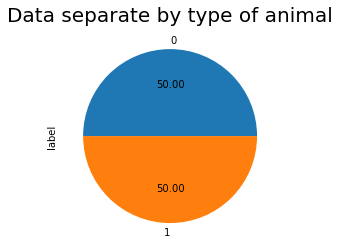

In [36]:
df["label"].value_counts().plot(kind = "pie", autopct = "%.2f" )
plt.title('Data separate by type of animal',fontsize=20)
plt.show()

### well, our data is balanced, lets look the data

In [46]:
df.describe(include = 'all')

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999,label
count,25000.000000,25000.00000,25000.00000,25000.00000,25000.00000,25000.000000,25000.00000,25000.000000,25000.00000,25000.000000,...,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,114.247960,114.59004,114.83796,115.22768,115.63592,115.998160,116.39900,116.634200,117.09612,117.218840,...,124.38460,123.940840,123.445560,122.939080,122.391840,121.836600,121.219080,120.753320,120.389880,0.50000
std,68.985043,68.77785,68.68357,68.64397,68.55194,68.444718,68.36624,68.424277,68.55232,68.467713,...,65.01052,65.040327,65.096998,65.242743,65.432194,65.511698,65.562679,65.605986,65.905611,0.50001
min,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,57.000000,58.00000,58.00000,58.00000,59.00000,60.000000,60.00000,61.000000,60.00000,61.000000,...,74.00000,73.000000,73.000000,72.000000,71.750000,71.000000,70.000000,69.000000,69.000000,0.00000
50%,108.000000,109.00000,109.00000,110.00000,111.00000,111.000000,112.00000,112.000000,113.00000,113.000000,...,123.00000,122.000000,121.000000,121.000000,120.000000,120.000000,119.000000,118.000000,117.000000,0.50000
75%,164.000000,165.00000,165.00000,165.00000,166.00000,166.000000,167.00000,167.000000,167.00000,168.000000,...,172.00000,171.000000,170.250000,170.000000,170.000000,169.000000,168.000000,168.000000,167.000000,1.00000
max,255.000000,255.00000,255.00000,255.00000,255.00000,255.000000,255.00000,255.000000,255.00000,255.000000,...,255.00000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,1.00000


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 10001 entries, pixel0 to label
dtypes: int64(10001)
memory usage: 1.9 GB


In [83]:
df.isnull().sum(axis=1).sum(axis=0)

0

## making new features

In [61]:
df['sum'] = df[column].sum(axis = 1)

## X-Y train split

In [73]:
y_train = df['label']
X_train = df.drop('label' , axis=1)

### pca

In [105]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X = pca.fit_transform(X_train)

In [113]:
X_train.shape

(25000, 10001)

## k-nn

In [112]:
knn = KNeighborsClassifier(n_neighbors=10)
cv = cross_val_score(knn , X_train , y_train , cv = kf , scoring = 'f1')
cv.mean()

0.5127087319141429

In [114]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
score = []
for k in range(1,30,2):
    
    knn = KNeighborsClassifier(n_neighbors=k)
    cv = cross_val_score(knn , X_train , y_train , cv = kf , scoring = 'f1')
    score.append(cv.mean())
score

[0.5164714934532563,
 0.540398014421344,
 0.5503887725481166,
 0.5606952720913534,
 0.5613671011946191,
 0.5680521844627846,
 0.5716301609541301,
 0.5740719061122954,
 0.5758450945500558,
 0.5804497441851658,
 0.5831736274417721,
 0.5856315038005736,
 0.588291049433461,
 0.5912378581373401,
 0.5932673902129524]

In [109]:
max(score)

0.5141091723786744

## desicion tree

In [94]:
DecisionTree = DecisionTreeClassifier()

scores_f1 = cross_val_score(DecisionTree, X, y_train, cv=4, scoring= 'f1')
scores_recall = cross_val_score(DecisionTree, X, y_train, cv=4, scoring= 'recall')
scores_precision = cross_val_score(DecisionTree, X, y_train, cv=4, scoring='precision')

print("The f1_score of Decision Tree is:" + str(scores_f1.mean()))
print("The recall_score of Decision Tree is:" + str(scores_recall.mean()))
print("The precision_score of Decision Tree is:" + str(scores_precision.mean()))

The f1_score of Decision Tree is:0.5462535348033617
The recall_score of Decision Tree is:0.548
The precision_score of Decision Tree is:0.5450747246971719


### import the test-data